<a href="https://colab.research.google.com/github/AmritangshuM/multi-class-wildlife-detection-yolo/blob/main/Data_Processing_YOLO_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class wildlife classification using YOLOv7

As a first Step we need to load data from Kaggle using Authentication



In [ ]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Then we load up the data from !kaggle datasets download -d antoreepjana/animals-detection-images-dataset

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d antoreepjana/animals-detection-images-dataset
!unzip /content/animals-detection-images-dataset.zip

## Initial EDA

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt


#data_dir="/content/gdrive/MyDrive/AMLTermProject"
data_dir="/content"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

train_classes=[os.path.basename(path) for path in all_train_subdir]
test_classes=[os.path.basename(path) for path in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

train_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_train_subdir}
test_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_test_subdir}

train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df



There is 80 classes in train dataset, and 80 classes in test dataset


,train,test
Kangaroo,98,43
Bull,47,73
Panda,91,19
Whale,287,52
Mouse,151,83
...,...,...
Zebra,181,31
Snail,370,114
Bear,87,39
Giraffe,298,23


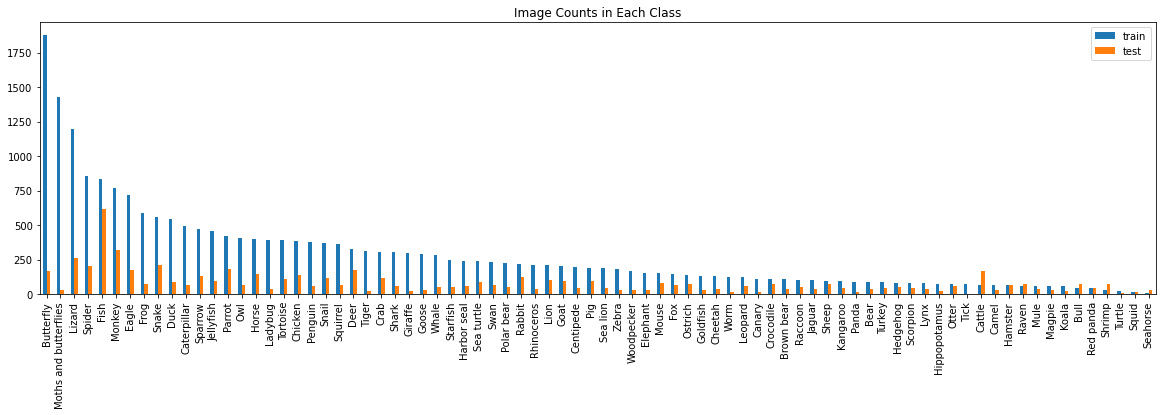

In [ ]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

Function to draw image using cv2

In [ ]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))    
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
        
            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)
        
    return image


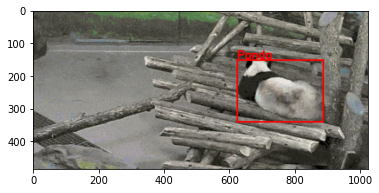

In [ ]:
subdir = all_train_subdir[2]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [ ]:
#os.chdir('/content/gdrive/MyDrive/AMLTermProject')

yolo_train_dir = "/content/yolo/train"
yolo_test_dir = "/content/yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

/content/yolo/train/images
/content/yolo/train/labels
/content/yolo/test/images
/content/yolo/test/labels


Function to process our dataset

In [ ]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            #print('check')
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
            if os.path.exists(label_file)==False:
                continue

            #print('check1')       
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        #print('check2')
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)
    

In [ ]:
os.chdir('/content/gdrive/MyDrive/AMLTermProject')

In [ ]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 665762.54it/s]


In [ ]:
animal_train_subdir=all_train_subdir
animal_classes=[os.path.basename(pp) for pp in animal_train_subdir]

process_dataset(animal_train_subdir, yolo_train_dir, animal_classes, size=(640,640), link=False) 

100%|██████████| 80/80 [08:23<00:00,  6.29s/it]


In [ ]:
animal_test_subdir=all_test_subdir
process_dataset(animal_test_subdir, yolo_test_dir, animal_classes, size=(640,640), link=False)  

100%|██████████| 80/80 [02:28<00:00,  1.86s/it]


## Clone YOLO github repository

In [ ]:
# Download YOLOv7 repository and install requirements
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

In [ ]:
# download COCO starting checkpoint
%cd /content/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
%%writefile cfg/training/yolov7_pothole-tiny.yaml
# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
 
# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32
 
# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2 
  
  [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4   
  
  [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
  
  [-1, 1, MP, []],  # 8-P3/8
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14
  
  [-1, 1, MP, []],  # 15-P4/16
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21
  
  [-1, 1, MP, []],  # 22-P5/32
  [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]
 
# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, SP, [5]],
  [-2, 1, SP, [9]],
  [-3, 1, SP, [13]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -7], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37
  
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, nn.Upsample, [None, 2, 'nearest']],
  [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
  [[-1, -2], 1, Concat, [1]],
  
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47
  
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, nn.Upsample, [None, 2, 'nearest']],
  [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
  [[-1, -2], 1, Concat, [1]],
  
  [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57
  
  [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, 47], 1, Concat, [1]],
  
  [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65
  
  [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, 37], 1, Concat, [1]],
  
  [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [[-1, -2, -3, -4], 1, Concat, [1]],
  [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73
      
  [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
  [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
 
  [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [ ]:
!cat /content/yolov7/data/coco.yaml

Generate YAML file

In [ ]:
yaml_file="/content/yolov7/data/animal_detect1.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")

names_str=""
for item in animal_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(animal_classes))
    wobj.write(names_str+"\n")

In [ ]:
!cat /content/yolov7/data/animal_detect1.yaml

train: /content/yolo/train/images
val: /content/yolo/test/images
nc: 80
names: [ 'Kangaroo', 'Bull', 'Panda', 'Whale', 'Mouse', 'Parrot', 'Rhinoceros', 'Ladybug', 'Starfish', 'Scorpion', 'Tiger', 'Horse', 'Magpie', 'Goose', 'Squirrel', 'Brown bear', 'Duck', 'Camel', 'Monkey', 'Shark', 'Harbor seal', 'Deer', 'Raven', 'Squid', 'Polar bear', 'Raccoon', 'Leopard', 'Sea lion', 'Woodpecker', 'Eagle', 'Snake', 'Tortoise', 'Fox', 'Mule', 'Lizard', 'Jaguar', 'Swan', 'Goldfish', 'Pig', 'Otter', 'Hedgehog', 'Centipede', 'Jellyfish', 'Cattle', 'Caterpillar', 'Koala', 'Turkey', 'Turtle', 'Sea turtle', 'Sparrow', 'Canary', 'Seahorse', 'Red panda', 'Worm', 'Frog', 'Rabbit', 'Hamster', 'Crocodile', 'Lynx', 'Chicken', 'Moths and butterflies', 'Spider', 'Ostrich', 'Elephant', 'Owl', 'Tick', 'Lion', 'Butterfly', 'Fish', 'Crab', 'Sheep', 'Goat', 'Shrimp', 'Hippopotamus', 'Cheetah', 'Zebra', 'Snail', 'Bear', 'Giraffe', 'Penguin']


Initialize WANDB

In [ ]:
!pip install "wandb==0.12.10"
import wandb
wandb.login()

Initialize model training

In [ ]:
# run this cell to begin training
%cd /content/yolov7
!python train.py --batch 16 --epochs 50 --workers 4 --data /content/animal_detect1.yaml --weights 'yolov7_training.pt' --cfg cfg/training/yolov7_pothole-tiny.yaml

Transfer weights learned to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp -av /content/yolov7/runs /content/gdrive/My\ Drive/AML/yolov7_transfer/

## Use learned wights to detect objects in images

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov7/detect.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov7/runs/train/Model2/weights/best.pt --source /content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg --name animals --project runs/detect

## Export weights in required format

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov7/export.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov7/runs/train/Model2/weights/best.pt --include onnx --simplify